In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import scipy.io
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [28]:
def Accuracy(compdata, data, Reconstructed):
    CR = len(compdata) / len(data)
    error = deepcopy(np.sqrt(np.sum((Reconstructed[:, 1] - data[:, 1]) ** 2)))
    energy = deepcopy(np.sqrt(np.sum((data[:, 1]) ** 2)))
    prd = error / energy
    print(f"CR: {1 / CR}")
    print(f"PRD: {prd * 100} %")

In [29]:
def Reconstruct(compdata, data):
    noncomp = [element for element in data[:, 0] if element not in compdata[:, 0]]
    interpolate = []
    for x in noncomp:
        y = EstimateY(x, compdata)
        interpolate.append([x, y])

    interpolate = np.array(interpolate).reshape(-1, 2)
    Reconstructed = np.append(interpolate, compdata, axis = 0)
    Reconstructed = Reconstructed[Reconstructed[:, 0].argsort()]
    return Reconstructed

In [30]:
def EstimateY(x, compdata):
    upper, lower = Bounds(x, compdata)
    slope = (upper[1] - lower[1])/(upper[0] - lower[0])
    datapointY = slope * (x - lower[0]) + lower[1]
    return datapointY


In [31]:
def Bounds(datapoint, compdata):
    upper = data[-1]
    lower = data[0]
    for i in range(len(compdata)):
        if compdata[i, 0] > datapoint:
            upper = deepcopy(compdata[i])
            break
    for i in range(len(compdata)):
        if compdata[len(compdata) - i - 1, 0] < datapoint:
            lower = deepcopy(compdata[len(compdata) - i - 1])
            break
    return upper, lower

In [32]:
def margin(base, point, upperslope, lowerslope):
    uppery = base[1] + upperslope * (point[0] - base[0])
    upper = [point[0], uppery]

    lowery = base[1] + lowerslope * (point[0] - base[0])
    lower = [point[0], lowery]

    upxs = [base[0], upper[0]]
    upys = [base[1], upper[1]]

    lowxs = [base[0], lower[0]]
    lowys = [base[1], lower[1]]
    return upper, lower, upxs, upys, lowxs, lowys

In [33]:
def SetSlopes(base, point, upper, lower, epsilon):
    newupper = [point[0], point[1] + epsilon]
    newlower = [point[0], point[1] - epsilon]

    upper = [point[0], min(upper[1], newupper[1])]
    lower = [point[0], max(lower[1], newlower[1])]

    upperslope = (upper[1] - base[1]) / (upper[0] - base[0])
    lowerslope = (lower[1] - base[1]) / (lower[0] - base[0])
    return upperslope, lowerslope

In [34]:
def Initialize(data, epsilon):
    x0 = data[0]
    x1 = data[1]
    upper = [x1[0], x1[1] + epsilon]
    lower = [x1[0], x1[1] - epsilon]
    upxs = [x0[0], upper[0]]
    upys = [x0[1], upper[1]]
    lowxs = [x0[0], lower[0]]
    lowys = [x0[1], lower[1]]
    upperslope = (upper[1] - x0[1]) / (upper[0] - x0[0])
    lowerslope = (lower[1] - x0[1]) / (lower[0] - x0[0])
    return upper, lower, upxs, upys, lowxs, lowys, upperslope, lowerslope, x0

In [35]:
def Run(data, x0, upperslope, lowerslope, epsilon):
    InsideBounds = True
    i = 1
    while(InsideBounds):
        i += 1
        point = data[i]
        upper, lower, upxs, upys, lowxs, lowys = margin(x0, point, upperslope, lowerslope)
        upperslope, lowerslope = SetSlopes(x0, point, upper, lower, epsilon)
        InsideBounds = lower[1] < point[1] < upper[1]
        
    return data[point[0] - 1], upxs, upys, lowxs, lowys

In [36]:
def FAN(data, epsilon):
    checkpoints = []

    while(len(data) > 2):
        upper, lower, upxs, upys, lowxs, lowys, upperslope, lowerslope, x0 = Initialize(data, epsilon)
        if len(checkpoints) == 0:
            checkpoints.append(x0)
        else:
            checkpoints.append([x0[0] + 1 + checkpoints[-1][0], x0[1]])
        checkpoint, upxs, upys, lowxs, lowys = Run(data, x0, upperslope, lowerslope, epsilon)
        checkpoints.append([ checkpoint[0] +  checkpoints[-1][0]   , checkpoint[1]])
        data = deepcopy(data[checkpoint[0] + 1:])
        data[:, 0] = data[:, 0] - data[0, 0]

    if len(data) == 1:
        checkpoints.append([1 + checkpoints[-1][0], data[0, 1]])


    checkpoints = np.array(checkpoints).reshape(-1, 2)
    return checkpoints

In [37]:
def ECG():
    data = scipy.io.loadmat('/content/drive/MyDrive/Depo/PhysioNet/223m (6).mat')['val'][0][0:497]
    data = data.reshape(-1, 1)
    x = np.arange(0, len(data), 1).reshape(-1, 1)
    data = np.append(x, data, axis= 1)
    return data

In [38]:
def EEG():
    data = np.array(pd.read_csv('/content/drive/MyDrive/Depo/PhysioNet/Auditory evoked potential EEG-Biometric dataset2.csv', header=None))[0:495]
    scaler.fit(data)
    data = scaler.transform(data)
    data = data * 1000
    x = np.arange(0, len(data), 1).reshape(-1, 1).astype(int)
    data = np.append(x, data.astype(int), axis= 1)
    return data

In [39]:
data = ECG()

Text(0.5, 1.0, 'Original Signal')

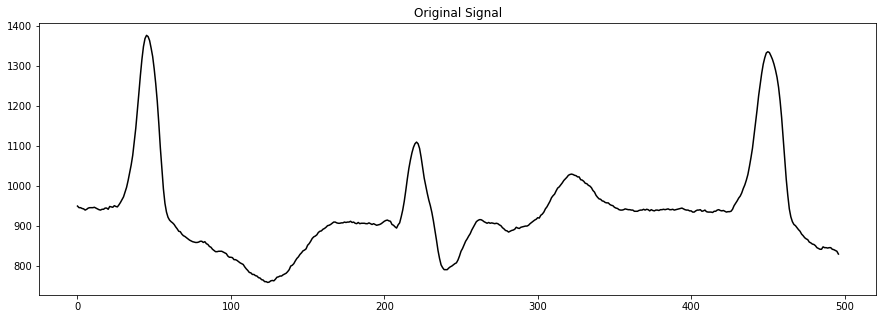

In [40]:
plt.figure(figsize= (15, 5))
plt.plot(data[:, 0], data[:, 1],  c= 'black')
plt.title('Original Signal')
#plt.plot(upxs, upys, c = 'b')
#plt.plot(lowxs, lowys, c = 'r')


In [41]:
epsilon = 7
compdata = FAN(data, epsilon)


Text(0.5, 1.0, 'Compressed Signal')

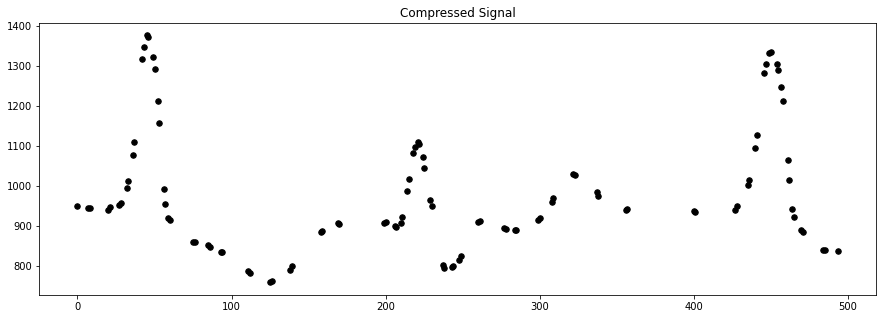

In [42]:
plt.figure(figsize= (15, 5))
plt.scatter(compdata[:, 0], compdata[:, 1], s= 30, c= 'black')
plt.title('Compressed Signal')

In [43]:
data = ECG()
Reconstructed =  Reconstruct(compdata, data)

Text(0.5, 1.0, 'Reconstructed Signal')

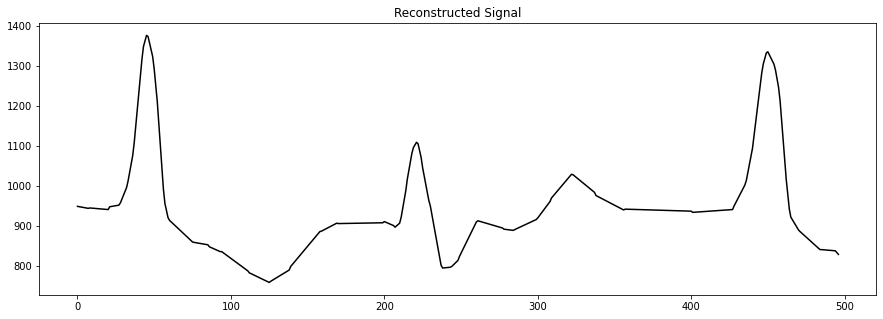

In [44]:
plt.figure(figsize= (15, 5))
plt.plot(Reconstructed[:, 0], Reconstructed[:, 1],  c= 'black')
plt.title('Reconstructed Signal')

In [45]:
Accuracy(compdata, data, Reconstructed)

CR: 4.872549019607843
PRD: 0.3533111585638952 %


In [46]:
data = EEG()

Text(0.5, 1.0, 'Original Signal')

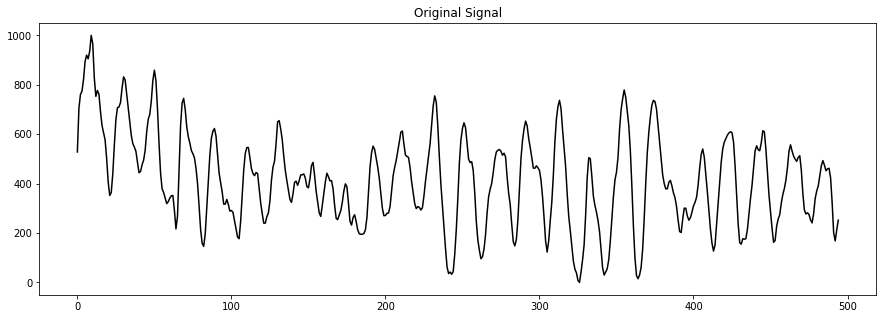

In [47]:
plt.figure(figsize= (15, 5))
plt.plot(data[:, 0], data[:, 1],  c= 'black')
plt.title('Original Signal')
#plt.plot(upxs, upys, c = 'b')
#plt.plot(lowxs, lowys, c = 'r')

In [48]:
epsilon = 50
compdata = FAN(data, epsilon)


Text(0.5, 1.0, 'Compressed Signal')

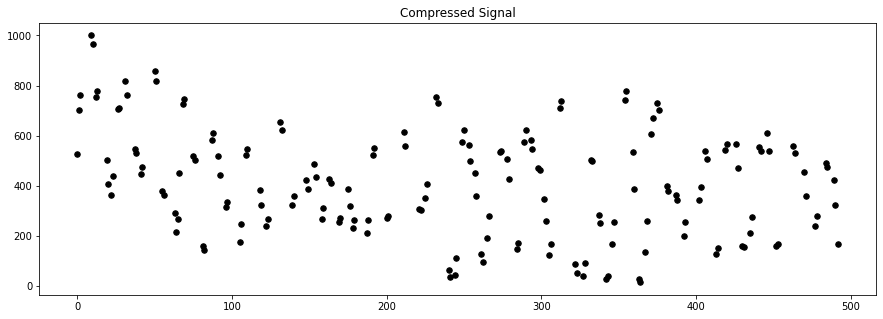

In [49]:
plt.figure(figsize= (15, 5))
plt.scatter(compdata[:, 0], compdata[:, 1], s= 30, c= 'black')
plt.title('Compressed Signal')

In [50]:
data = EEG()
Reconstructed =  Reconstruct(compdata, data)

Text(0.5, 1.0, 'Reconstructed Signal')

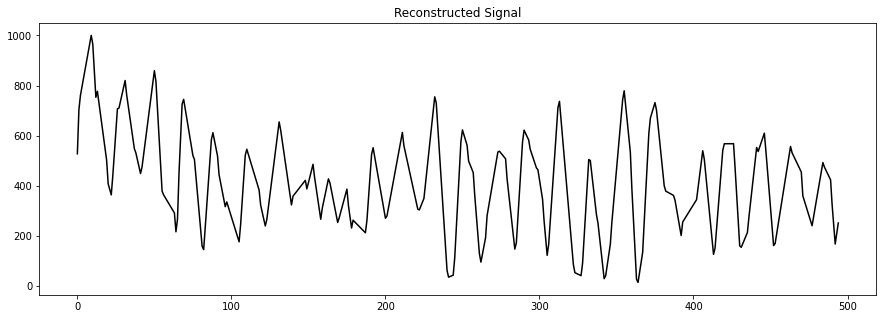

In [51]:
plt.figure(figsize= (15, 5))
plt.plot(Reconstructed[:, 0], Reconstructed[:, 1],  c= 'black')
plt.title('Reconstructed Signal')

In [52]:
Accuracy(compdata, data, Reconstructed)

CR: 2.877906976744186
PRD: 4.644817394404863 %
